## The Randomisation Test

The randomisation test, also called a permutation test, is a neat idea in statistics. The intuition is quite simple - under the null hypothesis, the label assigned to each sample is interchangeable because each sample came from a single distribution.  A randomisation test shuffles the labels assigned to each point and calculates the difference between both groups. If we do this repeatedly, we can build up a distribution of the differences between both groups. 

In the quick post below, I work through two examples from the book *Statistics for Experimenters*. In the first, I use a randomisation test in place of an independent samples t-test. In the second I use the same technique in place of a dependent samples t-test.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Comparison of Standard and Modified Fertilizer Mixtures for Tomato Plants

The following example was given in *Statistics for Experimenters* of data collected by a gardener who wanted to know which fertilizer mixture would result in the largest yield. The data is shown below

In [2]:
df = pd.DataFrame({'label': ['A', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'B'], 
                   'yield': [29.9, 11.4, 26.6, 23.7, 25.3, 28.5, 14.2, 17.9, 16.5, 21.1, 24.3]})
df.head()

,label,yield
0,A,29.9
1,A,11.4
2,B,26.6
3,B,23.7
4,A,25.3


#### Plot the Randomisation Distribution

In [3]:
point_estimate = df[df.label == 'B']['yield'].mean() - df[df.label == 'A']['yield'].mean()

num_simulations = 5000
differences = []
for _ in range(num_simulations):
    shuffled = np.random.permutation(df['label'])
    diff = df[shuffled == 'B']['yield'].mean() - df[shuffled == 'A']['yield'].mean()
    differences.append(diff)

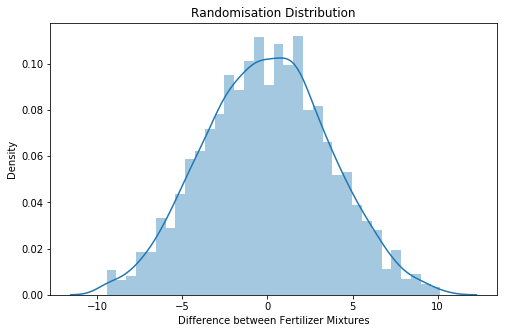

In [4]:
plt.figure(figsize=(8,5))
sns.distplot(differences)
plt.title('Randomisation Distribution')
plt.xlabel('Difference between Fertilizer Mixtures')
plt.ylabel('Density');

#### Plot the analytically derived t-distribution

In [5]:
def calculate_sum_squares(data, mean):
    return (np.square(np.subtract(data, mean))).sum()

def calculate_se(data1, data2):
    "Calculate the Pooled standard error of yb - ya"
    mean1, mean2 = data1.mean(), data2.mean()
    var1, var2 = calculate_sum_squares(data1, mean1), calculate_sum_squares(data2, mean2)
    pooled_var = (var1 + var2) / (len(data1) + len(data2) - 2)
    variance_of_diff = pooled_var * ((1/len(data1)) + (1/len(data2)))
    return np.sqrt(variance_of_diff)

In [6]:
# np.random.shuffle changes the dataframe in place so re-create below.
df = pd.DataFrame({'label': ['A', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'B'], 
                   'yield': [29.9, 11.4, 26.6, 23.7, 25.3, 28.5, 14.2, 17.9, 16.5, 21.1, 24.3]})

data1, data2 = df[df.label == 'B']['yield'], df[df.label == 'A']['yield']
mean = 0 # null hypothesis
se = calculate_se(data1, data2)

x = np.linspace(mean - 3*se, mean + 3*se, 1000)
degrees_freedom = len(data1) + len(data2) - 2
t_dist = scipy.stats.t(degrees_freedom, mean, se)

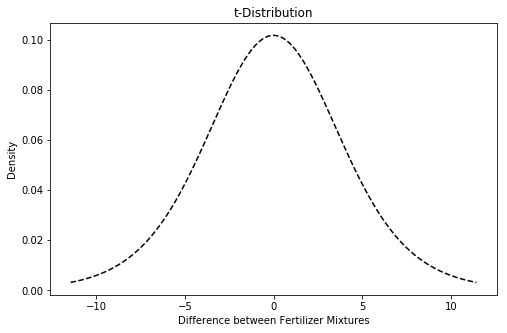

In [7]:
plt.figure(figsize=(8,5))
plt.plot(x, t_dist.pdf(x), linestyle='--', color='black')
plt.title('t-Distribution')
plt.xlabel('Difference between Fertilizer Mixtures')
plt.ylabel('Density');

#### Let's plot both on the same axis

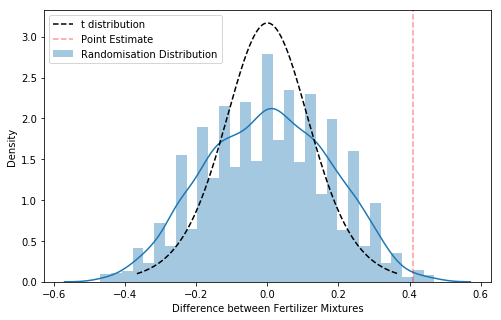

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.distplot(differences, hist=True, label='Randomisation Distribution', ax=ax);
plt.plot(x, t_dist.pdf(x), linestyle='--', label='t distribution', color='black')
ax.axvline(point_estimate, label='Point Estimate', linestyle='--', color='r', alpha=.4)

plt.xlabel('Difference between Fertilizer Mixtures')
plt.ylabel('Density')
ax.legend(loc='best');

#### Despite using different methodologies, both distributions follow each other closely. 

Computing the p-value associated with the observed difference is simple for the permutation test - we simply calculate how many observed samples had a difference equal to or greater than the observed difference (for a one-tailed test). The results from the t-distribution match up very closely.

In [9]:
# permutation test
p = len([d for d in differences if d >= point_estimate]) / num_simulations
print ("p-value obtained from the permutation test {:.4f}".format(p))

# analytical solution
t, p, dof = ttest_ind(df[df.label =='B']['yield'], df[df.label =='A']['yield'],
                      alternative = 'larger', 
                      usevar='pooled')
print ("p-value obtained from the independent samples t-test {:.4f}".format(p))

p-value obtained from the permutation test 0.3326
p-value obtained from the independent samples t-test 0.3339


***

### Boys Shoes' Design

Another example given in *Statistics for Experimenters* describes a paired design to determine the best material to use for shoe soles. Each boy wears material A on one foot and material B on the other; by making comparisons within matched pairs we remove the boy-to-boy variation, increasing the precision. 

This is another problem where we can use the randomisation distribution in place of the repeated samples t-test. The data is shown below showing the amount of wear shoe soles made of materials A and B.

In [10]:
df = pd.DataFrame({'label_a': [13.2, 8.2, 10.9, 14.3, 10.7, 6.6, 9.5, 10.8, 8.8, 13.3],
                   'label_b': [14, 8.8, 11.2, 14.2, 11.8, 6.4, 9.8, 11.3, 9.3, 13.6]})                
point_estimate = np.mean(df.label_b - df.label_a)
df.head()

,label_a,label_b
0,13.2,14.0
1,8.2,8.8
2,10.9,11.2
3,14.3,14.2
4,10.7,11.8


In this case we shuffle the values of label A and label B between samples (rows). This is because under the null hypothesis there is no difference in the materials and the value for label B could just have easily been recorded for label A. Repeatedly doing this constructs the sampling distribution.

In [11]:
# randomisation distribution
num_simulations = 5000
differences = []
for _ in range(num_simulations):
    df_shuffled = df.apply(np.random.permutation, axis=1, result_type='expand')
    df_shuffled.columns = ['label_a', 'label_b']
    mean_diff = np.mean(df_shuffled['label_b'] - df_shuffled['label_a'])
    differences.append(mean_diff)

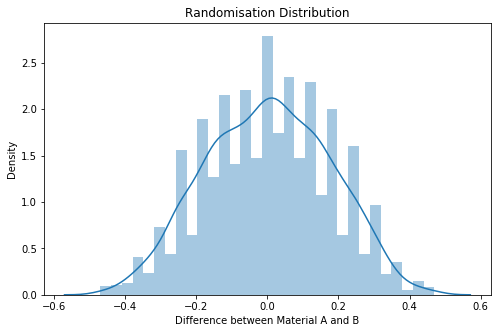

In [20]:
plt.figure(figsize=(8,5))
sns.distplot(differences)
plt.title('Randomisation Distribution')
plt.xlabel('Difference between Material A and B')
plt.ylabel('Density');

#### Plot the analytically derived t-distribution

In [13]:
# np.random.permutation changes the dataframe in place so re-create below.
df = pd.DataFrame({'label_a': [13.2, 8.2, 10.9, 14.3, 10.7, 6.6, 9.5, 10.8, 8.8, 13.3],
                   'label_b': [14, 8.8, 11.2, 14.2, 11.8, 6.4, 9.8, 11.3, 9.3, 13.6]})      

mean = 0 # null hypothesis
deg_freedom = len(df) - 1

def calculate_se (df):
    "Calculate Standard Error for Repeated t-test"
    d_average = np.mean(df.label_b - df.label_a)
    diff = (df.label_b - df.label_a) - d_average
    squared_diff = np.square(diff)
    sum_squared_diff = np.sum(squared_diff)
    var = sum_squared_diff / deg_freedom
    se = np.sqrt(var/len(df))
    return se

In [14]:
se = calculate_se(df)
x = np.linspace(mean - 3*se, mean + 3*se, 1000)
t_dist = scipy.stats.t(deg_freedom, mean, se)

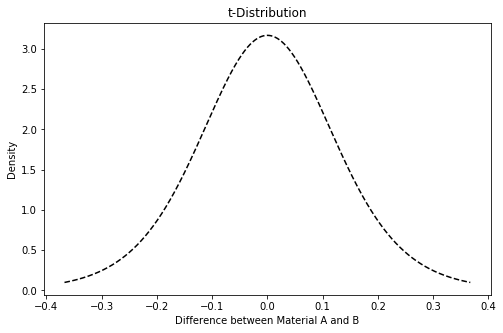

In [21]:
plt.figure(figsize=(8,5))
plt.plot(x, t_dist.pdf(x), linestyle='--', color='black')
plt.title('t-Distribution')
plt.xlabel('Difference between Material A and B')
plt.ylabel('Density');

#### Let's plot both on the same axis

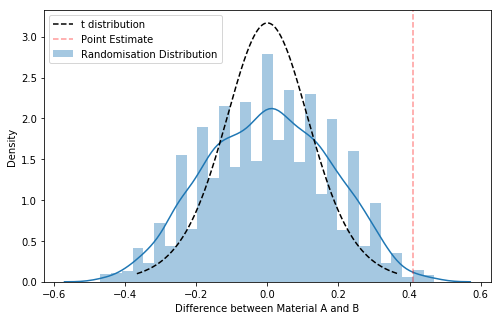

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.distplot(differences, hist=True, label='Randomisation Distribution', ax=ax);
plt.plot(x, t_dist.pdf(x), linestyle='--', label='t distribution', color='black')
ax.axvline(point_estimate, label='Point Estimate', linestyle='--', color='r', alpha=.4)

plt.xlabel('Difference between Material A and B')
plt.ylabel('Density')
ax.legend(loc='best');

Again we can compute a p-value. In this case we will perform a two-tailed test.

In [17]:
# permutation test
p = len([d for d in differences if abs(d) >= point_estimate]) / num_simulations
print ("p-value obtained from the permutation test {:.4f}".format(p))

# analytical solution
_ , p = scipy.stats.ttest_rel(df['label_b'], df['label_a'])
print ("p-value obtained from the dependent samples t-test {:.4f}".format(p))

p-value obtained from the permutation test 0.0130
p-value obtained from the dependent samples t-test 0.0085


### Conclusion and Acknowledgements

The randomisation distribution offers an intuitive computational alternative to more analytical statistical methods. I encourage you all to check out the linked talks below – both fantastic talks!

- [John Rauser keynote: "Statistics Without the Agonizing Pain"](https://youtu.be/5Dnw46eC-0o)
- [Jake Vanderplas - Statistics for Hackers](https://youtu.be/Iq9DzN6mvYA)